In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preprocessing


In [4]:
np.random.seed(500)
data = pd.read_csv("df_english_2_labelled.csv")

data_df = data[['Clean_texts','label']]

Corpus = data_df

# Corpus.dropna(inplace=True)
# tokens = df['label'].apply(word_tokenize)
# Corpus.head()
# Corpus



In [9]:

Corpus.dropna(inplace=True)
tokens = data_df['label'].apply(word_tokenize)
# Corpus.head()
# Corpus
Corpus['text_original'] = Corpus['Clean_texts']
# Corpus['text'] = [entry.lower() for entry in Corpus['content'] ]
Corpus['text']= [word_tokenize(entry) for entry in Corpus['Clean_texts']]
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV



In [13]:
for index,entry in enumerate(Corpus['text']):
#     entry = str(entry)
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
#     print(entry)
    for word, tag in pos_tag(entry):
#         print(word)
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    Corpus.loc[index,'text_final'] = str(Final_words)

In [14]:
# Corpus.drop(['text'], axis=1)
# Corpus.dropna(inplace=True)
# output_path = 'preprocessed_data.csv'
# Corpus.to_csv(output_path, index=False)

In [16]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['label'],test_size=0.3)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# print(Tfidf_vect.vocabulary_)

### SVN

In [17]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  66.85101970273072


In [4]:
print(classification_report(Test_Y,predictions_SVM))

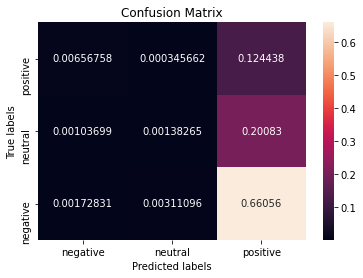

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt     

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Test_Y, predictions_SVM, normalize='all')
# cm = confusion_matrix(Test_Y, predictions_SVM)


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); 
ax.yaxis.set_ticklabels(['positive', 'neutral', 'negative']);

In [21]:
predictions_SVM

array([2, 2, 2, ..., 2, 2, 2])

### Naive Bayes Classifier


In [35]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  66.57449014863464


In [5]:
print(classification_report(Test_Y, predictions_NB))

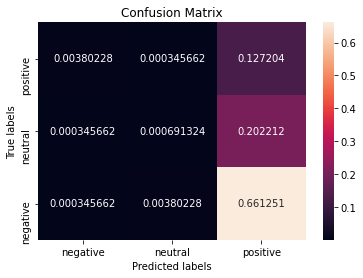

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt     

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Test_Y, predictions_NB, normalize='all')
# cm = confusion_matrix(Test_Y, predictions_SVM)


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); 
ax.yaxis.set_ticklabels(['positive', 'neutral', 'negative']);

### Random Forest


In [49]:
def prediction(X_test, model_object):
  
    # Predicton on test with giniIndex
    y_pred = model_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred

def cal_accuracy(y_test, y_pred):
      
    print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred))
      
    print ("Accuracy : ",
    accuracy_score(y_test,y_pred)*100)

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Decision tree with gini
model_gini = DecisionTreeClassifier(criterion = "gini",
            max_depth=10, min_samples_leaf=6)

# Performing training
# model_gini.fit(xv_train, y_train)

model_gini.fit(Train_X_Tfidf,Train_Y)
predictions_gini = prediction(Test_X_Tfidf,model_gini)

# Prediction using gini
# y_pred_gini = prediction(xv_test, model_gini)
cal_accuracy(Test_Y, predictions_gini )

Predicted values:
[2 2 2 ... 2 2 2]
Confusion Matrix:  [[  31    7  342]
 [  14   19  555]
 [  27   31 1867]]
Accuracy :  66.26339440027652


In [102]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier( n_estimators = 150,criterion = "gini", max_depth=50, min_samples_leaf=6)
model_rf.fit(Train_X_Tfidf,Train_Y)
predictions_rf = prediction(Test_X_Tfidf,model_rf)
cal_accuracy(Test_Y, predictions_rf )

Predicted values:
[2 2 2 ... 2 2 2]
Confusion Matrix:  [[  17    0  363]
 [   0    0  588]
 [   0    0 1925]]
Accuracy :  67.12754925682682


In [6]:
print(classification_report(Test_Y, predictions_rf))

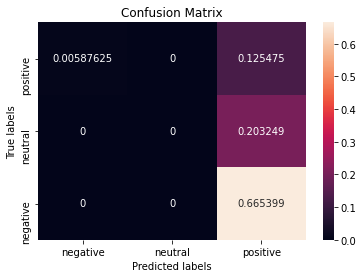

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt     

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Test_Y, predictions_rf, normalize='all')
# cm = confusion_matrix(Test_Y, predictions_SVM)


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); 
ax.yaxis.set_ticklabels(['positive', 'neutral', 'negative']);

In [7]:
print(classification_report(Test_Y, predictions_NB))

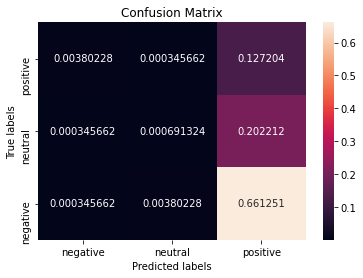

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt     

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Test_Y, predictions_NB, normalize='all')
# cm = confusion_matrix(Test_Y, predictions_SVM)


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); 
ax.yaxis.set_ticklabels(['positive', 'neutral', 'negative']);

In [106]:
from sklearn.metrics import cohen_kappa_score

eval_df = data_df.loc[:2000]

Encoder = LabelEncoder()
eval_df['rater1'] = Encoder.fit_transform(eval_df['rater1'])
eval_df['rater2'] = Encoder.fit_transform(eval_df['rater2'])
eval_df['rater3'] = Encoder.fit_transform(eval_df['rater3'])


rater1 = eval_df['rater1']
rater2 = eval_df['rater2']
rater3 = eval_df['rater3']
 
print("Cohen's kappa score between rater1 and rater2: ",cohen_kappa_score(rater1, rater2))
print("Cohen's kappa score between rater1 and rater3: ",cohen_kappa_score(rater1, rater3))
print("Cohen's kappa score between rater2 and rater3: ",cohen_kappa_score(rater2, rater3))

Cohen's kappa score between rater1 and rater2:  0.9883429672447014
Cohen's kappa score between rater1 and rater3:  0.986074613982929
Cohen's kappa score between rater2 and rater3:  0.9745305635970487
